<a href="https://colab.research.google.com/github/gehad-Ahmed30/Brain-Tumor-Deep-Learning-/blob/main/Brain_Tumor_using_EfficientNetB3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data Link: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

# Import needed modules

In [2]:
# import system libs
import os
from PIL import Image
import pathlib
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam,Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing

### **Read data and store it in dataframe**

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


## Train Data

In [4]:
train_data_dir='/kaggle/input/brain-tumor-mri-dataset/Training'
filepaths=[]
label=[]

folds=os.listdir(train_data_dir)
for fold in folds:
    foldpath=os.path.join(train_data_dir,fold)
    filelist=os.listdir(foldpath)
    for file in filelist:
        fpath=os.path.join(foldpath,file)

        filepaths.append(fpath)
        label.append(fold)

# Concatenate data paths with labels into one dataframe
fserises=pd.Series(filepaths,name='filepaths')
lserises=pd.Series(label,name='label')
train_df=pd.concat([fserises,lserises],axis=1)

In [5]:
train_df.head()

,filepaths,label
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary


## Test Data

In [6]:
# Generate data paths with labels
test_data_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
ts_df = pd.concat([Fseries, Lseries], axis= 1)

In [7]:
ts_df.head()

,filepaths,labels
0,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary


# Split dataframe into train, valid, and test

In [8]:
valid_df,test_df=train_test_split(ts_df,test_size=0.5,random_state=123)

# Create image data generator

In [9]:
batch_size=16
img_size=(224,224)
channels=3
img_shape=(img_size[0],img_size[1],channels)

tr_gen=ImageDataGenerator()   #convert img to tenser
ts_gen=ImageDataGenerator()

train_gen=tr_gen.flow_from_dataframe(train_df,x_col='filepaths',y_col='label',target_size=img_size,class_mode='categorical',color_mode='rgb',batch_size=batch_size,shuffle= True)
valid_gen=ts_gen.flow_from_dataframe(valid_df,x_col='filepaths',y_col='labels',target_size=img_size,class_mode='categorical',color_mode='rgb',batch_size=batch_size,shuffle= True)
test_gen=ts_gen.flow_from_dataframe(test_df,x_col='filepaths',y_col='labels',target_size=img_size,class_mode='categorical',color_mode='rgb',batch_size=batch_size,shuffle= False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


# Show sample from train data

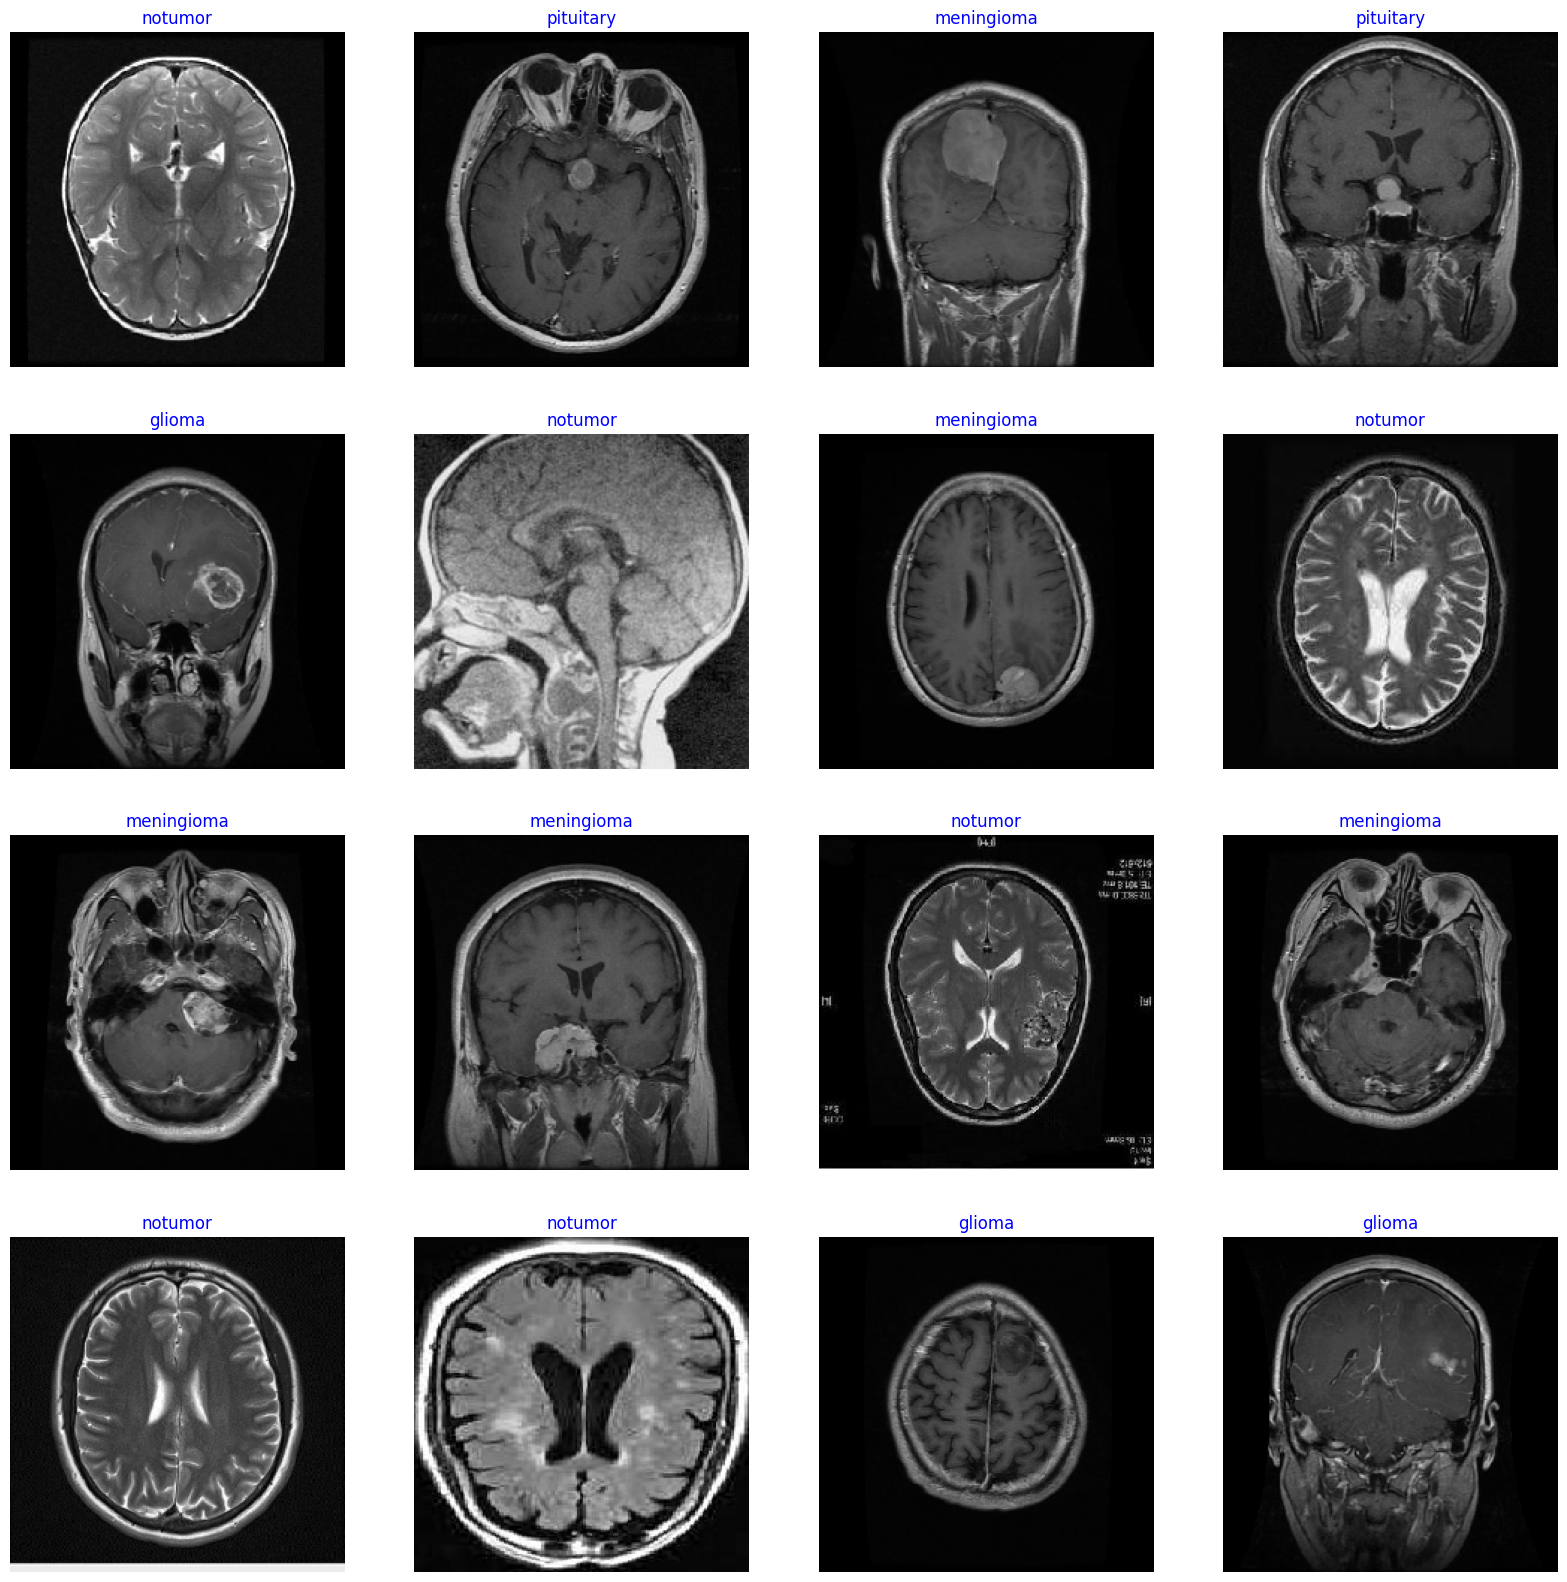

In [10]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# Model Structure

### Generic Model Creation

In [11]:
# Create Model Structure
img_size=(224,224)
channels=3
img_shape=(img_size[0],img_size[1],channels)  #224*224*4
class_count=len(list(train_gen.class_indices.keys()))  #4

# we will use efficientnetb3 from EfficientNet family.
base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False,weights='imagenet',input_shape=img_shape,pooling='max')      #include_top  100000
# efficientnetb0-->efficientnetb7  (b5,b6,b7 -->base_model.trainable = False  من غير تدريب خالص)
# base_model.trainable = False

model=Sequential([
    base_model,    # back for efficientnet + flatten
    BatchNormalization(axis=-1,momentum=0.99,epsilon=0.001),   #== Normalization (value between 0-1)
    Dense(256, kernel_regularizer= regularizers.l2(0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate=0.45,seed=123),
    Dense(class_count,activation='softmax')

])

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
model.compile(Adamax(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,184,179 (42.66 MB)

 Trainable params: 11,093,804 (42.32 MB)

 Non-trainable params: 90,375 (353.03 KB)

# Train model

In [20]:
epochs=15
history=model.fit(train_gen,validation_data=valid_gen,epochs=epochs,verbose=1,validation_steps=None,shuffle=False)

Epoch 1/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 54s 152ms/step - accuracy: 0.8872 - loss: 0.5668 - val_accuracy: 0.9847 - val_loss: 0.4406
Epoch 2/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 53s 148ms/step - accuracy: 0.8946 - loss: 0.5595 - val_accuracy: 0.9878 - val_loss: 0.4064
Epoch 3/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 53s 148ms/step - accuracy: 0.8919 - loss: 0.5665 - val_accuracy: 0.9878 - val_loss: 0.3924
Epoch 4/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 53s 148ms/step - accuracy: 0.8995 - loss: 0.5153 - val_accuracy: 0.9832 - val_loss: 0.3370
Epoch 5/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 84s 152ms/step - accuracy: 0.8912 - loss: 0.5458 - val_accuracy: 0.9252 - val_loss: 0.3688
Epoch 6/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 81s 150ms/step - accuracy: 0.8953 - loss: 0.5204 - val_accuracy: 0.9847 - val_loss: 0.3086
Epoch 7/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 53s 147ms/step - accuracy: 0.9041 - loss: 0.5215 - val_accuracy: 0.9985 - val_loss: 0.3002
Epoch 8/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 53s 148ms/step - accuracy: 0.9403 - loss: 0

# Display model performance

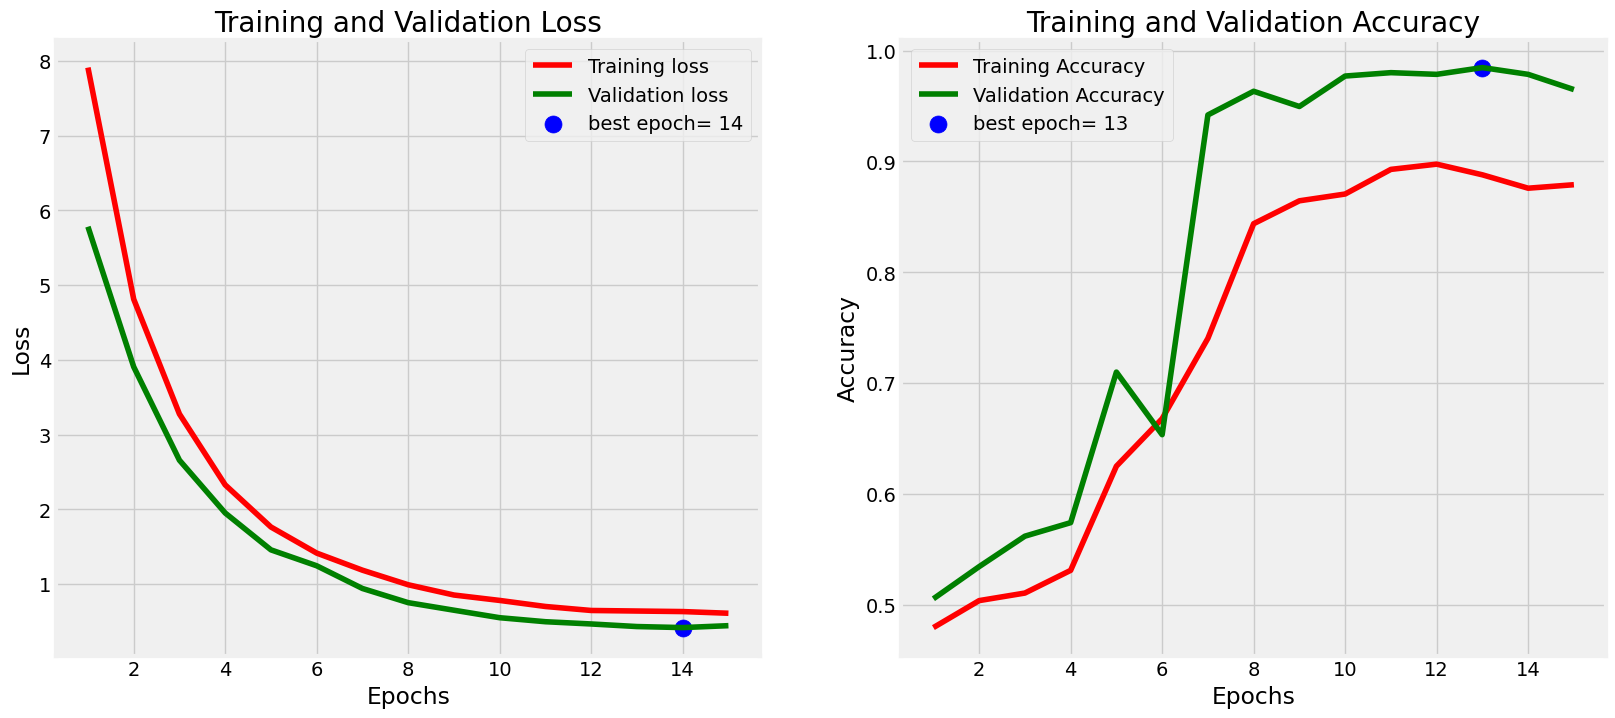

In [15]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# Evaluate model

In [16]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9696 - loss: 0.4156
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9801 - loss: 0.4290
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9758 - loss: 0.4330
Train Loss:  0.40655210614204407
Train Accuracy:  0.98046875
--------------------
Validation Loss:  0.43733930587768555
Validation Accuracy:  0.9765625
--------------------
Test Loss:  0.4386478662490845
Test Accuracy:  0.97265625


# Get Predictions

In [17]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step


In [18]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      glioma       0.99      0.90      0.94       149
  meningioma       0.94      0.97      0.95       143
     notumor       1.00      0.99      1.00       200
   pituitary       0.93      0.99      0.96       164

    accuracy                           0.97       656
   macro avg       0.97      0.96      0.96       656
weighted avg       0.97      0.97      0.97       656



# Save model

In [21]:
model.save('Brain Tumors.h5')